In [1]:
from openimages.download import download_dataset

In [2]:
classes = ['Screwdriver', 'Hammer', 'Wrench', 'Power plugs and sockets', 'Door handle']#, 'Nail (Construction)']

In [3]:
download_dir = '../data/raw/openimages-download-v0'
output_dir = '../data/raw/openimages-processed-v0'

In [4]:
data_dict = download_dataset(dest_dir=download_dir, class_labels=classes, annotation_format="darknet", limit=500)

2025-06-30  20:22:33 INFO Downloading 37 train images for class 'screwdriver'
100%|██████████| 37/37 [00:01<00:00, 27.70it/s]
2025-06-30  20:22:34 INFO Creating 37 train annotations (darknet) for class 'screwdriver'
100%|██████████| 37/37 [00:00<00:00, 2369.81it/s]
2025-06-30  20:22:35 INFO Downloading 53 train images for class 'hammer'
100%|██████████| 53/53 [00:01<00:00, 32.11it/s]
2025-06-30  20:22:36 INFO Creating 53 train annotations (darknet) for class 'hammer'
100%|██████████| 53/53 [00:00<00:00, 1265.20it/s]
2025-06-30  20:22:37 INFO Downloading 31 train images for class 'wrench'
100%|██████████| 31/31 [00:01<00:00, 25.14it/s]
2025-06-30  20:22:38 INFO Creating 31 train annotations (darknet) for class 'wrench'
100%|██████████| 31/31 [00:00<00:00, 984.00it/s]
2025-06-30  20:22:38 INFO Downloading 87 train images for class 'power plugs and sockets'
100%|██████████| 87/87 [00:02<00:00, 40.06it/s]
2025-06-30  20:22:41 INFO Creating 87 train annotations (darknet) for class 'power pl

In [5]:
data_dict

{'screwdriver': {'images_dir': '../data/raw/openimages-download-v0/screwdriver/images',
  'annotations_dir': '../data/raw/openimages-download-v0/screwdriver/darknet'},
 'hammer': {'images_dir': '../data/raw/openimages-download-v0/hammer/images',
  'annotations_dir': '../data/raw/openimages-download-v0/hammer/darknet'},
 'wrench': {'images_dir': '../data/raw/openimages-download-v0/wrench/images',
  'annotations_dir': '../data/raw/openimages-download-v0/wrench/darknet'},
 'power plugs and sockets': {'images_dir': '../data/raw/openimages-download-v0/power plugs and sockets/images',
  'annotations_dir': '../data/raw/openimages-download-v0/power plugs and sockets/darknet'},
 'door handle': {'images_dir': '../data/raw/openimages-download-v0/door handle/images',
  'annotations_dir': '../data/raw/openimages-download-v0/door handle/darknet'}}

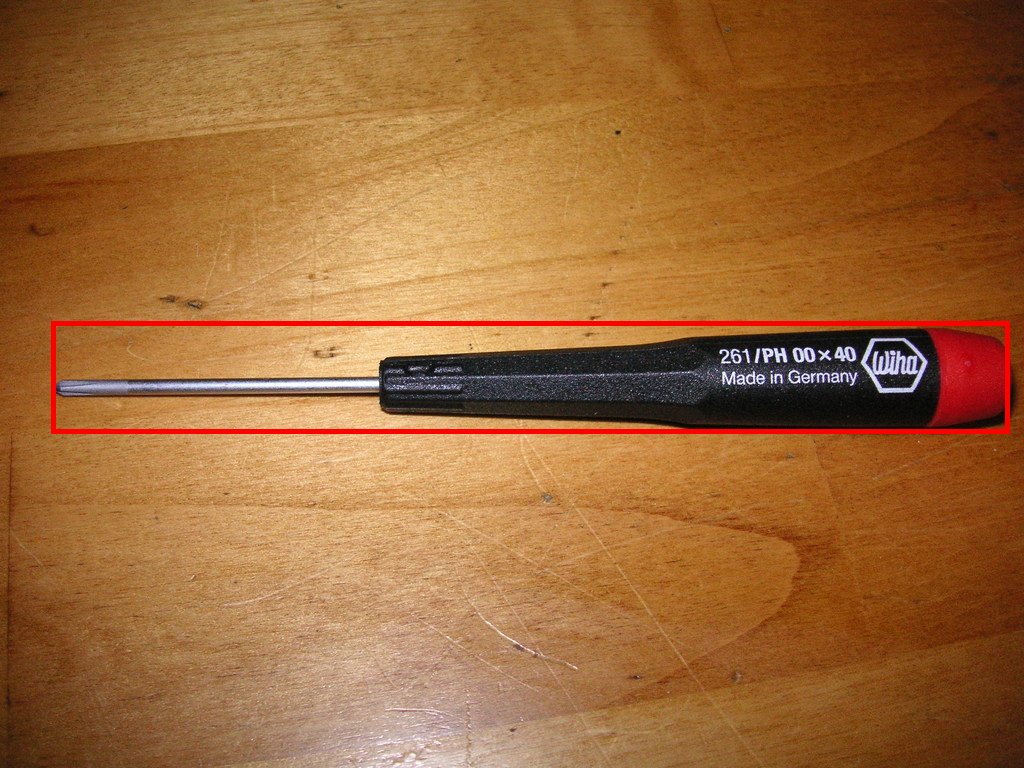

In [6]:
from PIL import Image, ImageDraw

def show_bbox(image_path):
    # convert image path to label path
    label_path = image_path.replace('/images/', '/darknet/')
    label_path = label_path.replace('.jpg', '.txt')

    # Open the image and create ImageDraw object for drawing
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    with open(label_path, 'r') as f:
        for line in f.readlines():
            # Split the line into five values
            label, x, y, w, h = line.split(' ')

            # Convert string into float
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)

            # Convert center position, width, height into
            # top-left and bottom-right coordinates
            W, H = image.size
            x1 = (x - w/2) * W
            y1 = (y - h/2) * H
            x2 = (x + w/2) * W
            y2 = (y + h/2) * H

            # Draw the bounding box with red lines
            draw.rectangle((x1, y1, x2, y2),
                           outline=(255, 0, 0), # Red in RGB
                           width=5)             # Line width
    image.show()
    
# Show a sample image with bounding boxes
# Get a valid filename
import os
images_dir = os.path.join(download_dir, 'screwdriver', 'images')
filename = os.path.join(images_dir, [f for f in os.listdir(images_dir) if f.endswith('.jpg')][0])
show_bbox(filename)

In [7]:
import os

# Create a folder structure for YOLOv5 training
if not os.path.exists(output_dir):
    for folder in ['images', 'labels']:
        for split in ['train', 'val', 'test']:
            os.makedirs(f'{output_dir}/{folder}/{split}')

In [8]:
import glob
import shutil

def get_filenames(folder):
    filenames = set()
    
    for path in glob.glob(os.path.join(folder, '*.jpg')):
        # Extract the filename
        filename = os.path.split(path)[-1]        
        filenames.add(filename)

    return filenames

def split_dataset(class_name, image_names, train_size, val_size, test_size):
    for i, image_name in enumerate(image_names):
        # Label filename
        label_name = image_name.replace('.jpg', '.txt')
        
        # Split into train, val, or test
        if i < train_size:
            split = 'train'
        elif i < train_size + val_size:
            split = 'val'
        elif i < train_size + val_size + test_size:
            split = 'test'
        
        # Source paths
        source_image_path = f'{download_dir}/{class_name}/images/{image_name}'
        source_label_path = f'{download_dir}/{class_name}/darknet/{label_name}'

        # Destination paths
        target_image_folder = f'{output_dir}/images/{split}'
        target_label_folder = f'{output_dir}/labels/{split}'

        # Copy files
        shutil.copy(source_image_path, target_image_folder)
        shutil.copy(source_label_path, target_label_folder)

In [9]:
import numpy as np

np.random.seed(0)
for class_name in classes:
	class_name = class_name.lower()
	# Get the filenames for the current class
	class_images = np.array(list(get_filenames(f'{download_dir}/{class_name}/images')))
	print(f'Class: {class_name}, Number of images: {len(class_images)}')
	np.random.shuffle(class_images)
	split_dataset(class_name, class_images, train_size=5, val_size=5, test_size=5)
	

Class: screwdriver, Number of images: 37
Class: hammer, Number of images: 53
Class: wrench, Number of images: 33
Class: power plugs and sockets, Number of images: 131
Class: door handle, Number of images: 500


In [10]:
import yaml

data = {
	'train': f'{output_dir}/images/train',
	'val': f'{output_dir}/images/val',
	'test': f'{output_dir}/images/test',
	'nc': len(classes),
	'names': [c.lower() for c in classes]
}

# Create the YAML file
dataset_name = download_dir.split('/')[-1].replace('download', 'data')
with open(f'../data/{dataset_name}.yaml', 'w') as outfile:
	yaml.dump(data, outfile, default_flow_style=False)